<a href="https://colab.research.google.com/github/pmugambiwa97/Gaborone-Infrastructure-Flood-Risk/blob/main/botswana_southeast_region_road_flood_risk2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geemap xee geopandas    # xee - xee is an extension to open GEE ImageCollections directly as Xarray Datasets
import ee
import geemap
import xee
import xarray as xr         # treats satellite images like "Data Cubes" (Xarray); for stacking data.
import matplotlib.pyplot as plt
import pandas as pd         # messy rainfall data into clean table for analysis
import geopandas as gpd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.1/472.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24


In [2]:
# Establish a connection between ee and colab environment
ee.Authenticate()
ee.Initialize(
    project = 'gaborone-road-flood-risk2025',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)


In [3]:
global_map = geemap.Map(basemap = 'TERRAIN', ee_initialize = False)
global_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
location = global_map.draw_last_feature.geometry()
print(location)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Point",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      23.549546,
                      -21.841488
                    ]
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})


In [5]:
# call international boundary and filter based on the target country. Target country = Botswana

botswana = (
    ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
    .filterBounds(location)
)

botswana

In [6]:
global_map.addLayer(botswana, {}, 'Botswana')

In [7]:
# Print all available Level 1 names in Botswana
print(ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Botswana')).aggregate_array('ADM1_NAME').getInfo())

['Central', 'Chobe', 'Ghanzi', 'Kgalagadi', 'Kgatleng', 'Kweneng', 'Ngamiland', 'North East', 'South-East', 'Southern']


In [8]:
gaborone_region = (
    ee.FeatureCollection("FAO/GAUL/2015/level1")
    .filter(ee.Filter.eq('ADM1_NAME', 'South-East'))

)

gaborone_region

In [9]:
global_map.addLayer(gaborone_region, {'color': 'FF0000'}, 'South-East Region Boundary')

global_map.centerObject(gaborone_region, 12)

### **Precipitation Analysis and Event Identification**

---



In [10]:
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
filtered_rainfall = chirps.filter(ee.Filter.date('2024-09-01', '2025-12-31')) \
    .filterBounds(gaborone_region) \
    .select('precipitation')

In [11]:
filtered_rainfall.size().getInfo()

456

In [12]:
def calculate_daily_avg_rainfall(single_day_image):
# Calculate the average rainfall over Gaborone for this one day
  region_rainfall = single_day_image.reduceRegion(
      reducer = ee.Reducer.mean(),
      geometry = gaborone_region.geometry(),
      scale = 5566,
      maxPixels = 1e13
  )

  #Turn results into 1 row of data
  return ee.Feature(
      None,
      {
          'date': single_day_image.date().format('YYYY-MM-dd'),
          'precipitation': region_rainfall.get('precipitation')
      }
  )


# Apply this to every day in the dataset
daily_rainfall_table = filtered_rainfall.map(calculate_daily_avg_rainfall)




In [13]:
# Get a list of dictionaries with each feature's properties
features = daily_rainfall_table.getInfo()['features']

print(features)


[{'type': 'Feature', 'geometry': None, 'id': '20240901', 'properties': {'date': '2024-09-01', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240902', 'properties': {'date': '2024-09-02', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240903', 'properties': {'date': '2024-09-03', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240904', 'properties': {'date': '2024-09-04', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240905', 'properties': {'date': '2024-09-05', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240906', 'properties': {'date': '2024-09-06', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240907', 'properties': {'date': '2024-09-07', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240908', 'properties': {'date': '2024-09-08', 'precipitation': 0}}, {'type': 'Feature', 'geometry': None, 'id': '20240909', 'properties': {'date': 

In [14]:
daily_data_list = []            # holds each day's data as a dictionary
for feature in features:
    feature_properties = feature['properties']      # access "properties" dictionary
    daily_data_list.append({
        'date': feature_properties['date'],                    # store date
        'precipitation': feature_properties['precipitation']     # store ppt'n
    })

# convert the processed list of dictionaries into a pandas dataframe
rainfall_df = pd.DataFrame(daily_data_list)

# Convert the date column from string to datetime
rainfall_df['date'] = pd.to_datetime(rainfall_df['date'])

# Convert precipitation from meters to millimeters
rainfall_df['rainfall_mm'] = rainfall_df['precipitation']

# Group by date to remove duplicates (take mean if multiple entries per day)
rainfall_df = rainfall_df.groupby('date', as_index=False).mean()

# sort according to date
rainfall_df = rainfall_df.sort_values(by = 'date')

# Keep only relevant columns
rainfall_df = rainfall_df[['date', 'rainfall_mm']]

rainfall_df.head()
rainfall_df[rainfall_df['rainfall_mm'] > 0]


,date,rainfall_mm
9,2024-09-10,1.171217e+00
10,2024-09-11,3.019608e+00
11,2024-09-12,4.074021e-06
12,2024-09-13,9.937707e-06
14,2024-09-15,3.498163e-07
...,...,...
451,2025-11-26,4.063013e-05
452,2025-11-27,9.212685e+00
453,2025-11-28,2.130670e+00
454,2025-11-29,4.722969e-05


In [15]:
len(rainfall_df)

456

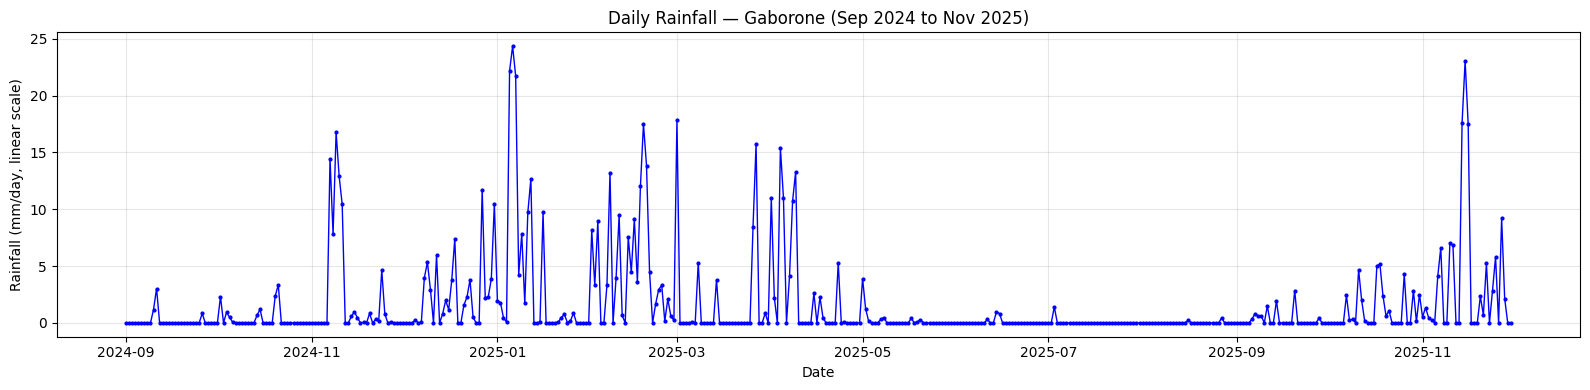

In [16]:
plt.figure(figsize=(16, 4))
plt.plot(
    rainfall_df['date'],
    rainfall_df['rainfall_mm'],
    color = 'blue',
    marker = 'o',
    linewidth = 1,
    markersize = 2,
    linestyle = '-'
)

plt.title('Daily Rainfall — Gaborone (Sep 2024 to Nov 2025)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm/day, linear scale)')
plt.grid(True, alpha = 0.3)
plt.tight_layout()

plt.savefig('southeast_rainfall_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
# Create month and wet-day columns
rainfall_df['month'] = rainfall_df['date'].dt.to_period('M') # keeps year + month
rainfall_df['wet_day'] = rainfall_df['rainfall_mm'] >= 10    # 15 mm/day chosen as a dataset-relative threshold to capture wet days for CHIRPS-based flood analysis

# Check number of wet days per month
wet_days_per_month = rainfall_df.groupby('month')['wet_day'].sum() # group by year_month

print(wet_days_per_month)

wet_months = wet_days_per_month[wet_days_per_month > 0].index.astype(str).tolist()

print("Wet months chosen for composite creation:")
print(wet_months)

month
2024-09    0
2024-10    0
2024-11    4
2024-12    2
2025-01    4
2025-02    4
2025-03    2
2025-04    5
2025-05    0
2025-06    0
2025-07    0
2025-08    0
2025-09    0
2025-10    0
2025-11    3
Freq: M, Name: wet_day, dtype: int64
Wet months chosen for composite creation:
['2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-11']


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Sep 2024'),
  Text(1, 0, 'Oct 2024'),
  Text(2, 0, 'Nov 2024'),
  Text(3, 0, 'Dec 2024'),
  Text(4, 0, 'Jan 2025'),
  Text(5, 0, 'Feb 2025'),
  Text(6, 0, 'Mar 2025'),
  Text(7, 0, 'Apr 2025'),
  Text(8, 0, 'May 2025'),
  Text(9, 0, 'Jun 2025'),
  Text(10, 0, 'Jul 2025'),
  Text(11, 0, 'Aug 2025'),
  Text(12, 0, 'Sep 2025'),
  Text(13, 0, 'Oct 2025'),
  Text(14, 0, 'Nov 2025')])

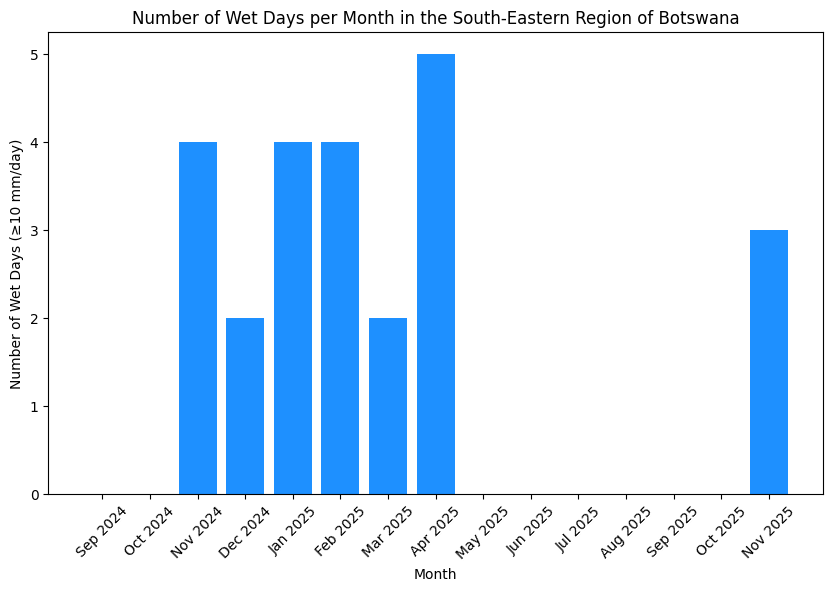

In [18]:
# Convert month numbers to names
import calendar

month_names = wet_days_per_month.index.to_timestamp().strftime('%b %Y')


# Assign colors: wet months vs dry months
colors = ['dodgerblue' if value > 0 else 'lightgray'
          for value in wet_days_per_month.values]

plt.figure(figsize=(10, 6))
plt.bar(month_names, wet_days_per_month.values, color= colors)
plt.xlabel('Month')
plt.ylabel('Number of Wet Days (≥10 mm/day)')
plt.title('Number of Wet Days per Month in the South-Eastern Region of Botswana')
# plt.tight_layout()
plt.xticks(rotation=45)

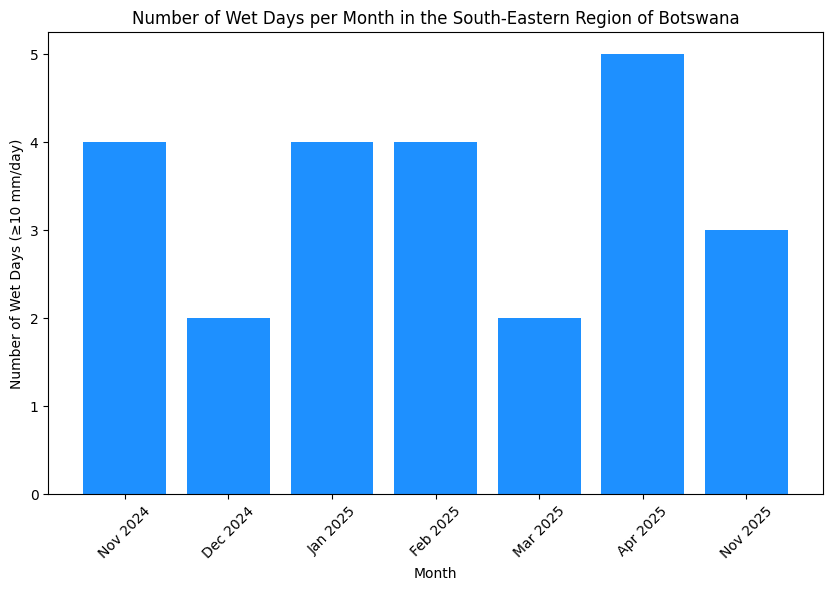

In [19]:
# isolate months where number of wet days are greater than 0


# Remove months with zero wet days
nonzero_days = wet_days_per_month[wet_days_per_month > 0]

# Convert month numbers to names
month_names = nonzero_days.index.to_timestamp().strftime('%b %Y')

plt.figure(figsize=(10, 6))
plt.bar(month_names, nonzero_days.values, color= 'dodgerblue')
plt.xlabel('Month')
plt.ylabel('Number of Wet Days (≥10 mm/day)')
plt.title('Number of Wet Days per Month in the South-Eastern Region of Botswana')
# plt.tight_layout()
plt.xticks(rotation=45)

plt.savefig('wet_days_per_month.png', dpi=300, bbox_inches='tight')

plt.show()

In [20]:
rainfall_df['year_month'] = rainfall_df['date'].dt.to_period('M')     # convert each date to a month period

monthly_rainfall = rainfall_df.groupby('year_month').agg(
    tot_rain_mm = ('rainfall_mm', 'sum'),
    wet_days = ('rainfall_mm', lambda x: (x >= 10).sum())
).reset_index()


monthly_rainfall

dry_baseline_months = monthly_rainfall[monthly_rainfall['tot_rain_mm'] <= 3]


In [21]:
three_driest_months = monthly_rainfall.nsmallest(3, 'tot_rain_mm')
print("Driest months with total rainfall:")
for i in range(len(three_driest_months)):
    month = three_driest_months['year_month'].iloc[i]
    rain = three_driest_months['tot_rain_mm'].iloc[i]
    print(month, "with total rainfall =", round(rain, 2), "mm")


Driest months with total rainfall:
2025-08 with total rainfall = 0.69 mm
2025-07 with total rainfall = 1.4 mm
2025-06 with total rainfall = 2.13 mm


### **Wet and Dry Master Images - Sentinel-1 Radar (SAR)**

---



In [22]:
# Basic Sentinel-1 availability check for full project period
sent1_data_test = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(gaborone_region)
    .filterDate('2024-09-01', '2025-12-01')
)

print(
    "Raw Sentinel-1 images over Gaborone (Sep 2024 – Nov 2025):",
    sent1_data_test.size().getInfo()
)

Raw Sentinel-1 images over Gaborone (Sep 2024 – Nov 2025): 106


In [23]:
iw_data = sent1_data_test.filter(ee.Filter.eq('instrumentMode', 'IW'))

print("After IW filter:", iw_data.size().getInfo())

After IW filter: 106


In [24]:
vv_data = iw_data.filter(
    ee.Filter.listContains('transmitterReceiverPolarization', 'VV')
)

print("After VV filter:", vv_data.size().getInfo())

After VV filter: 0


In [25]:
vv_band = vv_data.select('VV')

print("After selecting VV band:", vv_band.size().getInfo())

After selecting VV band: 0


In [26]:
all_gaborone_region_images = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(gaborone_region).filterDate('2024-09-01', '2025-12-01')
print(f"1. Total Raw Images: {all_gaborone_region_images.size().getInfo()}")


iw_images = all_gaborone_region_images.filter(ee.Filter.eq('instrumentMode', 'IW'))
print(f"2. Total IW Mode Images: {iw_images.size().getInfo()}")

vv_images = iw_images.filter(ee.Filter.listContains('transmitterReceiverPolarization', 'VV'))
print(f"3. Total IW + VV Images: {vv_images.size().getInfo()}")

1. Total Raw Images: 106
2. Total IW Mode Images: 106
3. Total IW + VV Images: 0


In [27]:
# Look at the image in your 106-image collection to see its bands
sample_image = all_gaborone_region_images.first()
print("Available Bands in these 106 images:", sample_image.bandNames().getInfo())

# Check the polarization list for that same image
print("Actual Polarization labels:", sample_image.get('transmitterReceiverPolarization').getInfo())

Available Bands in these 106 images: ['VV', 'VH', 'angle']
Actual Polarization labels: None


In [28]:
sent1_new = all_gaborone_region_images.select(['VV', 'VH'])

all_months = ['2024-09','2024-10','2024-11','2024-12','2025-01','2025-02','2025-03',
              '2025-04','2025-05','2025-06','2025-07','2025-08','2025-09','2025-10','2025-11']

for month in all_months:
    start = month + '-01'
    end = ee.Date(start).advance(1, 'month')
    collection = sent1_new.filterDate(start, end)
    num_images = collection.size().getInfo()
    print(f"{month}: {num_images} images available")

2024-09: 5 images available
2024-10: 5 images available
2024-11: 5 images available
2024-12: 5 images available
2025-01: 5 images available
2025-02: 4 images available
2025-03: 8 images available
2025-04: 7 images available
2025-05: 10 images available
2025-06: 10 images available
2025-07: 10 images available
2025-08: 10 images available
2025-09: 7 images available
2025-10: 7 images available
2025-11: 8 images available


In [29]:
vv_radar_signal = sent1_new.select('VV')

dry_months_total = vv_radar_signal.filterDate('2025-06-01', '2025-08-31')
dry_master = dry_months_total.median().clip(gaborone_region)

global_map.centerObject(gaborone_region, 12)


global_map.addLayer(dry_master, {'min': -25, 'max': 0}, 'Dry Master Baseline (Jun-Aug)')    # radar (dB values) for dry land are in this range

print("Dry Master defined and added to Map successfully!")

Dry Master defined and added to Map successfully!


In [31]:
wet_months_chosen = ee.Filter.Or(
    ee.Filter.date('2024-11-01', '2024-11-30'),
    ee.Filter.date('2025-01-01', '2025-04-30'),
    ee.Filter.date('2025-11-01', '2025-11-30')
)

wet_months_total = vv_radar_signal.filter(wet_months_chosen)

# use min backscatter - a place covered in water acts like a mirror - min to ignore the dry days and only picks wet areas (Schlaffer et al., 2015)
wet_master = wet_months_total.min().clip(gaborone_region)

global_map.centerObject(gaborone_region, 12)


global_map.addLayer(wet_master, {'min': -25, 'max': 0}, 'Wet Master Peak (Selected Months)')

print(f"Wet Master created using {wet_months_total.size().getInfo()} specific flood-period images.")
print("Wet Master defined and added to Map successfully!")

Wet Master created using 36 specific flood-period images.
Wet Master defined and added to Map successfully!


### **Change Detection Calculations**

---

In [33]:
flood_change_intensity = dry_master.subtract(wet_master).rename('Flood Intensity Score')

change_detection_visualisation = {
    'min': 5,            #low severity (minor change)           #numbers chosen according to Schlaffer et al., 2015
    'max': 15,           #high severity (significant flood)
    'palette': ['#ffffff00', 'orange', 'red']
}

global_map.addLayer(flood_change_intensity, change_detection_visualisation, 'General Flood Intensity for South Eastern Region')

global_map.centerObject(gaborone_region, 12)

print(f"Change Detection complete. Flood intensity score added to map.")

Change Detection complete. Flood intensity score added to map.


In [34]:
ee.batch.Export.image.toDrive(
    image = flood_change_intensity,
    description = 'South-Eastern Region_Flood_Intensity_2025',
    folder = 'GEE_Flood_Project',
    fileNamePrefix = 'flood_intensity_score_map',
    scale = 10,              # Resolution of Sentinel-1 is 10 meters
    region = gaborone_region,
    fileFormat = 'GeoTIFF'
).start()

### **Road Intersection - DEM**

In [35]:
# Elevaton Data first       ***Remember to move up after
se_elevation = ee.Image("NASA/NASADEM_HGT/001").select('elevation').clip(gaborone_region)

# Flat areas < 2 degrees at risk for standing water

se_slope = ee.Terrain.slope(se_elevation)
se_hillshade = ee.Terrain.hillshade(se_elevation)


flat_areas = se_slope.lte(2).rename('stagnation_zones')

dem_visualisation = {
    'min': 900,
    'max': 1600,      # Increased to capture Kgale and Oodi Hills accurately
    'palette': ['#1a9850', '#91cf60', '#d9ef8b', '#fee08b', '#fc8d59', '#d73027', '#ffffff']
}


global_map.addLayer(se_hillshade, {'min': 150, 'max': 255}, '3D Hillshade Shadows')
global_map.addLayer(se_elevation, dem_visualisation, '1. Elevation (Topography)', True, 0.5)
global_map.addLayer(flat_areas.updateMask(flat_areas), {'palette': ['#2c3e50']}, '2. Stagnation Zones (Flood Risk Sinks)')

global_map.centerObject(gaborone_region, 12)

print("Section 1 Complete: Terrain foundation set with 1600m range and <= 2° logic.")

Section 1 Complete: Terrain foundation set with 1600m range and <= 2° logic.


### **Add Road Layers**

In [36]:
hdx_roads = ee.FeatureCollection('projects/gaborone-road-flood-risk2025/assets/se_region_roads_updated')

se_region_roads = hdx_roads.filterBounds(gaborone_region)

drivable_roads = se_region_roads.filter(ee.Filter.inList('highway', ['residential', 'primary', 'secondary', 'trunk', 'tertiary']))

global_map.addLayer(drivable_roads, {'color': '#333333', 'width': 1}, '4. Gaborone Road Skeleton')

global_map.centerObject(gaborone_region, 12)

print("Section 2 Complete: Roads added. You can now see which streets are in the flat zones.")

Section 2 Complete: Roads added. You can now see which streets are in the flat zones.


### **Road-Flood Intersections (Flood Intensity Map**


#### *This part aims to show flooding was "strongest" or "deepest" on the roads relative to the dry baseline.*

In [37]:
road_flood_mask = drivable_roads.draw(color='black', strokeWidth=1).select([0]).mask()

road_flood_intersection = flood_change_intensity \
    .updateMask(road_flood_mask) \
    .updateMask(flat_areas)

global_map.addLayer(road_flood_intersection, {'min': 5,
     'max': 15, 'palette': ['#8e44ad', '#ff00ff']},
    '5. Road-Flood Intersection')

print(f"Road-Flood intersection created successfully")

Road-Flood intersection created successfully


### **Hotspot Frequency Map**

#### *This part aims to show how often the road was underwater. We are moving from from a single-event detection to identifying long-term "Danger Zones"*.

In [38]:
def get_flood_mask(start_date, end_date):

    monthly_collection = sent1_new.filterBounds(gaborone_region) \
                                  .filterDate(start_date, end_date)

    # Intensity relative to your dry baseline
    monthly_mean = monthly_collection.mean().select('VV')
    intensity = dry_master.subtract(monthly_mean)

    # Return Binary Mask: 1 if Intensity > 5 (Flooded), else 0
    return intensity.gt(5)


mask_nov24 = get_flood_mask('2024-11-01', '2024-11-30')
mask_early25 = get_flood_mask('2025-01-01', '2025-04-30')
mask_nov25 = get_flood_mask('2025-11-01', '2025-11-30')

In [39]:
total_frequency = mask_nov24.add(mask_early25).add(mask_nov25)

longterm_road_hotspots = total_frequency.updateMask(road_flood_mask) \
                                       .updateMask(flat_areas)

global_map.addLayer(longterm_road_hotspots,
    {'min': 2, 'max': 3, 'palette': ['orange', 'red']},
    '6. FINAL: Road Flood Frequency (2024-2025)')

print(f"Hotsport frequency map created successfully")

Hotsport frequency map created successfully


In [41]:
# Create dictionary
all_project_layers = {
    '01_Dry_Master_Baseline': dry_master,
    '02_Wet_Master_Peak': wet_master,
    '03_General_Flood_Intensity': flood_change_intensity,
    '04_Elevation_Topography': se_elevation,
    '05_Stagnation_Zones_Flat': flat_areas,
    '06_Gaborone_Road_Skeleton': drivable_roads,
    '07_Road_Flood_Intersection_Purple': road_flood_intersection,
    '08_FINAL_Road_Flood_Frequency': longterm_road_hotspots
}


for name, img in all_project_layers.items():

    if isinstance(img, ee.Image):
        task = ee.batch.Export.image.toDrive(
            image = img.clip(gaborone_region),
            description = name,
            folder = 'GEE_Flood_Project',
            scale = 10,
            region = gaborone_region.geometry(),
            fileFormat = 'GeoTIFF',
            maxPixels = 1e13
        )
    else:

        task = ee.batch.Export.table.toDrive(
            collection = img,
            description = name,
            folder = 'GEE_Flood_Project',
            fileFormat = 'SHP'
        )

    task.start()
    print(f'Successfully started export for: {name}')

Successfully started export for: 01_Dry_Master_Baseline
Successfully started export for: 02_Wet_Master_Peak
Successfully started export for: 03_General_Flood_Intensity
Successfully started export for: 04_Elevation_Topography
Successfully started export for: 05_Stagnation_Zones_Flat
Successfully started export for: 06_Gaborone_Road_Skeleton
Successfully started export for: 07_Road_Flood_Intersection_Purple
Successfully started export for: 08_FINAL_Road_Flood_Frequency
